## Part I: Data Pre-processing

In [4]:
import pandas as pd

In [2]:
# Download the Google Analogy dataset
!wget http://download.tensorflow.org/data/questions-words.txt

'wget' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC


In [1]:
# Preprocess the dataset
file_name = "database/questions-words"
with open(f"{file_name}.txt", "r") as f:
    data = f.read().splitlines()

In [22]:
# check data from the first 10 entries
for entry in data[:10]:
    print(entry)

: capital-common-countries
Athens Greece Baghdad Iraq
Athens Greece Bangkok Thailand
Athens Greece Beijing China
Athens Greece Berlin Germany
Athens Greece Bern Switzerland
Athens Greece Cairo Egypt
Athens Greece Canberra Australia
Athens Greece Hanoi Vietnam
Athens Greece Havana Cuba


In [2]:
# TODO1: Write your code here for processing data to pd.DataFrame
# Please note that the first five mentions of ": " indicate `semantic`,
# and the remaining nine belong to the `syntatic` category.
# Processing the data again with the correct logic

if isinstance(data, list):
    data = "\n".join(data)

lines = data.strip().split('\n')

# Create lists to store processed data
questions = []
categories = []
sub_categories = []

# Track how many times we've seen a subcategory with ": " (for semantic count)
semantic_subcategory_count = 0

for line in lines:
    if line.startswith(": "):  # New subcategory starts with ": "
        subcategory = line.strip()
        # If we have seen fewer than 5 semantic subcategories, mark as semantic
        category = 'Semantic' if semantic_subcategory_count < 5 else 'Syntactic'
        semantic_subcategory_count += 1
        continue
    else:
        # Add the question, category (semantic/syntactic), and subcategory
        questions.append(line.strip())
        categories.append(category)
        sub_categories.append(subcategory)

In [5]:
# Create the dataframe
df = pd.DataFrame(
    {
        "Question": questions,
        "Category": categories,
        "SubCategory": sub_categories,
    }
)

In [23]:
df.head()

,Question,Category,SubCategory
0,Athens Greece Baghdad Iraq,Semantic,: capital-common-countries
1,Athens Greece Bangkok Thailand,Semantic,: capital-common-countries
2,Athens Greece Beijing China,Semantic,: capital-common-countries
3,Athens Greece Berlin Germany,Semantic,: capital-common-countries
4,Athens Greece Bern Switzerland,Semantic,: capital-common-countries


(增加)統計每個 SubCategory 的行數，覺得會有 imbalance 的問題 

In [9]:
# 統計每個 SubCategory 的行數
sub_category_counts = df['SubCategory'].value_counts()

# 輸出每個 SubCategory 及其對應的行數
print(sub_category_counts)

SubCategory
: capital-world                  4524
: city-in-state                  2467
: gram6-nationality-adjective    1599
: gram7-past-tense               1560
: gram3-comparative              1332
: gram8-plural                   1332
: gram4-superlative              1122
: gram5-present-participle       1056
: gram1-adjective-to-adverb       992
: gram9-plural-verbs              870
: currency                        866
: gram2-opposite                  812
: capital-common-countries        506
: family                          506
Name: count, dtype: int64


In [9]:
df.to_csv(f"{file_name}.csv", index=False)

## Part II: Use pre-trained word embeddings
- After finish Part I, you can run Part II code blocks only.

In [34]:
import pandas as pd
import numpy as np
import gensim.downloader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [45]:
data = pd.read_csv("questions-words.csv")

In [6]:
MODEL_NAME = "word2vec-google-news-300"
# You can try other models.
# https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models

# Load the pre-trained model (using GloVe vectors here)
model = gensim.downloader.load(MODEL_NAME)
print("The Gensim model loaded successfully!")

[==================================================] 100.0% 1662.8/1662.8MB downloaded
The Gensim model loaded successfully!


In [6]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm( data["Question"]):
      # TODO2: Write your code here to use pre-trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """
      # 將類比問題拆解成四個單詞，例如： "man", "woman", "king", "queen"
      word_a, word_b, word_c, word_d = analogy.split()

      # 確保這些單詞存在於模型中
      if word_a in model and word_b in model and word_c in model:
          # 計算向量
          result_vector = model[word_b] + model[word_c] - model[word_a]

          # 找到最接近的單詞
          predicted_word = model.most_similar([result_vector], topn=1)[0][0]  # 獲取最接近的單詞作為字符串

          # 將預測結果與正確答案（word_d）保存下來
          preds.append(predicted_word)
          golds.append(word_d)
      else:
          missing_words = [word for word in [word_a, word_b, word_c] if word not in model]
          print(f"Missing words: {missing_words}")
          preds.append(None)
          golds.append(word_d)

import pandas as pd

# 創建一個 DataFrame 包含 preds 和 golds
results_df = pd.DataFrame({
    'Predictions': preds,
    'Golds': golds
})

# 儲存 DataFrame 為 CSV 檔案
results_df.to_csv('predictions_and_golds.csv', index=False)
print("Predictions and golds saved to predictions_and_golds.csv")


Predictions and golds saved to predictions_and_golds.csv


In [8]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: Semantic, Accuracy: 17.352576389671892%
Category: Syntactic, Accuracy: 22.53864168618267%
Sub-Category: capital-common-countries, Accuracy: 35.37549407114625%
Sub-Category: capital-world, Accuracy: 20.424403183023873%
Sub-Category: currency, Accuracy: 7.390300230946882%
Sub-Category: city-in-state, Accuracy: 7.90433725172274%
Sub-Category: family, Accuracy: 34.980237154150196%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 1.7137096774193548%
Sub-Category: gram2-opposite, Accuracy: 1.8472906403940887%
Sub-Category: gram3-comparative, Accuracy: 37.61261261261261%
Sub-Category: gram4-superlative, Accuracy: 20.855614973262032%
Sub-Category: gram5-present-participle, Accuracy: 6.0606060606060606%
Sub-Category: gram6-nationality-adjective, Accuracy: 75.73483427141964%
Sub-Category: gram7-past-tense, Accuracy: 10.32051282051282%
Sub-Category: gram8-plural, Accuracy: 5.03003003003003%
Sub-Category: gram9-plural-verbs, Accuracy: 15.632183908045977%


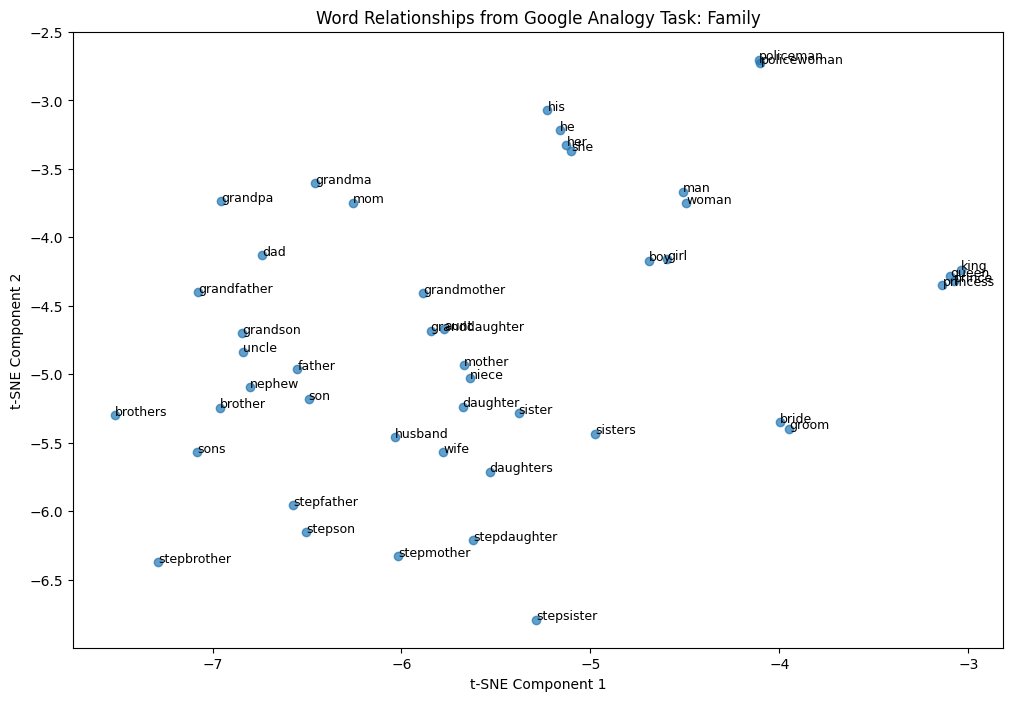

In [10]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO3: Plot t-SNE for the words in the SUB_CATEGORY `: family`

# 過濾出子類別為 ": family" 的問題
family_data = data[data["SubCategory"] == SUB_CATEGORY]

# 提取單詞
words = set()  # 使用集合以避免重複
for analogy in family_data["Question"]:
    words.update(analogy.split())

words = list(words)  # 轉換為列表

# 儲存字詞與對應的向量
word_vectors = []
valid_words = []

for word in words:
    if word in model:  # 確保單詞在詞模型中
        word_vectors.append(model[word])
        valid_words.append(word)

# 將詞向量轉換為 NumPy 陣列
word_vectors = np.array(word_vectors)

# 使用 t-SNE 降維
tsne = TSNE(n_components=2, random_state=42)
word_vectors_tsne = tsne.fit_transform(word_vectors)

# 繪製 t-SNE 圖
plt.figure(figsize=(12, 8))
plt.scatter(word_vectors_tsne[:, 0], word_vectors_tsne[:, 1], alpha=0.7)

# 標記每個點
for i, word in enumerate(valid_words):
    plt.annotate(word, (word_vectors_tsne[i, 0], word_vectors_tsne[i, 1]), fontsize=9)

plt.title("Word Relationships from Google Analogy Task: Family")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# 保存圖形
plt.savefig("word_relationships.png", bbox_inches="tight")
plt.show()




### Part III: Train your own word embeddings

### Get the latest English Wikipedia articles and do sampling.
- Usually, we start from Wikipedia dump (https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2). However, the downloading step will take very long. Also, the cleaning step for the Wikipedia corpus ([`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus)) will take much time. Therefore, we provide cleaned files for you.

In [5]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles).
# !gdown --id 1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd -O wiki_texts_part_0.txt.gz
# !gdown --id 1ABblLRd9HXdXvaNv8H9fFq984bhnowoG -O wiki_texts_part_1.txt.gz
# !gdown --id 1z2VFNhpPvCejTP5zyejzKj5YjI_Bn42M -O wiki_texts_part_2.txt.gz
# !gdown --id 1VKjded9BxADRhIoCzXy_W8uzVOTWIf0g -O wiki_texts_part_3.txt.gz
# !gdown --id 16mBeG26m9LzHXdPe8UrijUIc6sHxhknz -O wiki_texts_part_4.txt.gz

In [6]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles), except the last file.
# !gdown --id 17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI -O wiki_texts_part_5.txt.gz
# !gdown --id 19IvB2vOJRGlrYulnTXlZECR8zT5v550P -O wiki_texts_part_6.txt.gz
# !gdown --id 1sjwO8A2SDOKruv6-8NEq7pEIuQ50ygVV -O wiki_texts_part_7.txt.gz
# !gdown --id 1s7xKWJmyk98Jbq6Fi1scrHy7fr_ellUX -O wiki_texts_part_8.txt.gz
# !gdown --id 17eQXcrvY1cfpKelLbP2BhQKrljnFNykr -O wiki_texts_part_9.txt.gz
# !gdown --id 1J5TAN6bNBiSgTIYiPwzmABvGhAF58h62 -O wiki_texts_part_10.txt.gz

In [13]:
# Extract the downloaded wiki_texts_parts files.
!gunzip -k wiki_texts_part_*.gz

'gunzip' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC


In [14]:
# Combine the extracted wiki_texts_parts files.
!cat wiki_texts_part_*.txt > wiki_texts_combined.txt

'cat' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC


In [15]:
# Check the first ten lines of the combined file
!head -n 10 wiki_texts_combined.txt

'head' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC


自己處理檔案(解壓縮)

In [7]:
import gzip
import os
from tqdm import tqdm

# 解壓縮檔案
input_file = "wiki_texts_combined.txt.gz"
output_file = "wiki_texts_combined.txt"

# 獲取壓縮檔案的大小
input_size = os.path.getsize(input_file)

#用chatGPT 撰寫解壓縮程式碼
with gzip.open(input_file, 'rb') as f_in:
    with open(output_file, 'wb') as f_out:
        # 使用 tqdm 顯示進度條
        with tqdm(total=input_size, unit='B', unit_scale=True, desc='Decompressing') as pbar:
            # 分塊讀取並寫入
            buffer_size = 4096  # 讀取緩衝區大小
            while True:
                buffer = f_in.read(buffer_size)
                if not buffer:
                    break
                f_out.write(buffer)
                pbar.update(len(buffer))  # 更新進度條

print(f'已將 {input_file} 解壓縮為 {output_file}')


Decompressing: 20.8GB [03:44, 92.8MB/s]                            

Decompressed wiki_texts_combined.txt.gz to wiki_texts_combined.txt


In [18]:
# Check the first ten lines of the combined file
# 查看文件的前十行
with open("wiki_texts_combined.txt", "r", encoding="utf-8") as f:
    for _ in range(10):
        print(f.readline().strip())  # 使用 strip() 去掉行尾的換行符


anarchism is political philosophy and movement that is against all forms of authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy typically including the state and capitalism anarchism advocates for the replacement of the state with stateless societies and voluntary free associations as historically left wing movement this reading of anarchism is placed on the farthest left of the political spectrum usually described as the libertarian wing of the socialist movement libertarian socialism although traces of anarchist ideas are found all throughout history modern anarchism emerged from the enlightenment during the latter half of the th and the first decades of the th century the anarchist movement flourished in most parts of the world and had significant role in workers struggles for emancipation various anarchist schools of thought formed during this period anarchists have taken part in several revolutions most notably in the paris commune

Please note that we used the default parameters of [`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus) for cleaning the Wiki raw file. Thus, words with one character were discarded.

Sample

In [7]:
# Now you need to do sampling because the corpus is too big.
# You can further perform analysis with a greater sampling ratio.
#用chatGPT 生成sample架構我再修正，因為用一般的方式會 out of ram
import random
from tqdm import tqdm

sample_ratio = 0.2  # 抽樣比例
wiki_txt_path = "database/wiki_texts_combined.txt"
# wiki_texts_combined.txt is a text file separated by linebreaks (\n).
# Each row in wiki_texts_combined.txt indicates a Wikipedia article.
output_path = "database/sampled_wiki_texts-2.txt"  # 指定輸出文件的路徑

reservoir = []  # 存儲樣本
total_lines = 0  # 總行數

# with open(wiki_txt_path, "r", encoding="utf-8") as f:
#     with open(output_path, "w", encoding="utf-8") as output_file:
#     # TODO4: Sample `20%` Wikipedia articles
#     # Write your code here

# 首先獲取文件的總行數，以便設置進度條的長度
with open(wiki_txt_path, "r", encoding="utf-8") as f:
    total_lines = sum(1 for _ in f)  # 計算行數

with open(wiki_txt_path, "r", encoding="utf-8") as f:
    # 使用 tqdm 顯示進度條
    for line in tqdm(f, total=total_lines, desc="Sampling Progress"):
        # 抽樣邏輯
        if len(reservoir) < int(total_lines * sample_ratio):
            reservoir.append(line)
        else:
            replace_index = random.randint(0, total_lines - 1)
            if replace_index < len(reservoir):
                reservoir[replace_index] = line

# 將蓄水池內容寫入輸出文件
with open(output_path, "w", encoding="utf-8") as output_file:
    output_file.writelines(reservoir)


Sampling Progress: 100%|██████████| 5623655/5623655 [07:32<00:00, 12431.55it/s]


轉成 DataFrame (比較好觀察)


In [1]:
# TODO5: Train your own word embeddings with the sampled articles
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
# Hint: You should perform some pre-processing before training.
# 轉成 DataFrame
import pandas as pd

# 定義輸入檔案路徑
input_file_path = 'database/sampled_wiki_texts.txt'

# 讀取 TXT 檔案並建立 DataFrame
df = pd.read_csv(input_file_path, header=None, names=["text"])

# 顯示 DataFrame 的前幾行以確認
print(df.head())


                                                text
0  anarchism is political philosophy and movement...
1  newcastle municipality is local municipality w...
2  or is the first letter and the first vowel let...
3  in greek mythology achaeus or achaios ancient ...
4  harris kenneth wangelin may june was united st...


Preprocessing 

In [41]:
import logging
import time
import re
import nltk
from nltk.corpus import stopwords
import spacy
from tqdm import tqdm  # 用於顯示進度條
import re 

Clean Data

In [2]:
#參考 https://www.kaggle.com/code/mehmetisik/text-preprocessing-visualization-wikipedia-nlp

# 函數：文本清理
def clean_text(text):
    """
    清理並預處理文本數據：
    - 轉小寫
    - 移除標點符號
    - 移除數字
    - 移除換行符
    """
    # 初始化進度條
    tqdm.pandas(desc="Cleaning text")

    # 轉小寫
    text = text.progress_apply(lambda x: x.lower())
    # 移除標點符號、數字和換行符
    text = text.progress_apply(lambda x: re.sub(r'[^\w\s]', '', x))
    text = text.progress_apply(lambda x: re.sub("\n", '', x))
    text = text.progress_apply(lambda x: re.sub('\d', '', x))

    return text

# 調用 clean_text 函數進行處理
df["text"] = clean_text(df["text"])
df.to_csv('output.csv', index=False)

Cleaning text: 100%|██████████| 1124731/1124731 [00:35<00:00, 31324.90it/s]


stopwords

In [3]:
# 參考 https://www.kaggle.com/code/mehmetisik/text-preprocessing-visualization-wikipedia-nlp
# GPT 添加 tqdm
# 下載 NLTK 的停用詞

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 確保 tqdm 可以與 pandas 一起使用
tqdm.pandas(desc="Removing stopwords")

# 停用詞處理
def remove_stopwords(text):
    """
    從文本數據中移除停用詞。

    該函數會從文本數據中過濾掉常見的停用詞。
    停用詞是基於 NLTK 的英語停用詞列表進行移除。

    參數:
    text (pandas.Series): 包含文本數據的 pandas Series。

    返回:
    pandas.Series: 移除了停用詞的文本數據 Series。
    """
    # 使用進度條移除停用詞
    text = text.progress_apply(lambda x: " ".join(word for word in str(x).split() if word not in stop_words))
    return text

# 假設 df 已經存在，並包含名為 'text' 的列
df["text"] = remove_stopwords(df["text"])
df.to_csv('output.csv', index=False)  # index=False 是為了不保存行索引
# 打印結果以確認
print(df["text"])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\丁驥\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Removing stopwords: 100%|██████████| 1124731/1124731 [02:29<00:00, 7524.84it/s]


0          anarchism political philosophy movement forms ...
1          newcastle municipality local municipality with...
2          first letter first vowel letter latin alphabet...
3          greek mythology achaeus achaios ancient greek ...
4          harris kenneth wangelin may june united states...
                                 ...                        
1124726    wibald early july th century abbot stavelot st...
1124727    angle view pioneer sx stereo receiver pioneer ...
1124728    emilia cruz born mexican american artist known...
1124729    hans joachim schneider november june german ju...
1124730    kadhal kottai indian tamil language romantic d...
Name: text, Length: 1124731, dtype: object


Tokenlize (> 40hr，太久了不做) 

In [23]:
import pandas as pd
import spacy
from tqdm import tqdm

# 加載 SpaCy 模型
nlp = spacy.load("en_core_web_sm")

# 使用 tqdm 包裝 apply 函數以顯示進度條
tqdm.pandas(desc="Tokenizing text")

# 分詞處理
def spacy_tokenize(text):
    doc = nlp(text)
    return [token.text for token in doc]

# 將文本進行分詞處理並新增一列保存結果
df["tokenized_text"] = df["text"].progress_apply(spacy_tokenize)

print(df[["text", "tokenized_text"]])


Lemmatization (90 min)

In [24]:
# 參考 https://www.kaggle.com/code/mehmetisik/text-preprocessing-visualization-wikipedia-nlp
# GPT 添加 tqdm

from textblob import Word  # 用於詞形還原
# 確保 tqdm 可以與 pandas 一起使用
tqdm.pandas(desc="Lemmatizing text")

def apply_lemmatization(df, column_name):
    
    # 進行詞形還原並顯示進度條
    df[column_name] = df[column_name].progress_apply(
        lambda x: " ".join([Word(word).lemmatize() for word in x.split()])
    )

    return df

# 假設 df 已經存在，並包含名為 'text' 的列
df = apply_lemmatization(df, 'text')

# 打印結果以確認
print(df['text'])


Lemmatizing text: 100%|██████████| 1124731/1124731 [37:47<00:00, 496.04it/s] 


0          anarchism political philosophy movement form a...
1          newcastle municipality local municipality with...
2          first letter first vowel letter latin alphabet...
3          greek mythology achaeus achaios ancient greek ...
4          harris kenneth wangelin may june united state ...
                                 ...                        
1124726    wibald early july th century abbot stavelot st...
1124727    angle view pioneer sx stereo receiver pioneer ...
1124728    emilia cruz born mexican american artist known...
1124729    han joachim schneider november june german jur...
1124730    kadhal kottai indian tamil language romantic d...
Name: text, Length: 1124731, dtype: object


存成新的 txt 檔案

In [27]:
# 將 DataFrame 存儲為 TXT 文件
df.to_csv('./final/preprocessed_data.txt', sep='\t', index=False)

print("DataFrame 已存為 preprocessed data.txt")

DataFrame 已存為 preprocessed data.txt


做 10% sample ，且不做lemmatization

In [8]:
# 讀取 output.csv
df = pd.read_csv('output.csv')

# 隨機取 1/2 的樣本
df = df.sample(frac=0.5, random_state=42)

# 將 DataFrame 存儲為 TXT 文件
df.to_csv('./final/preprocessed_data_without_lemmatization.txt', sep='\t', index=False)  
print("DataFrame 已存為 preprocessed_data_without_lemmatization.txt")

DataFrame 已存為 preprocessed_data_without_lemmatization.txt


Model Training

In [10]:
# 參考 https://sfhsu29.medium.com/nlp-%E5%B0%88%E6%AC%84-1-2-%E5%A6%82%E4%BD%95%E8%A8%93%E7%B7%B4%E8%87%AA%E5%B7%B1%E7%9A%84-word2vec-5a0754c5cb09
import multiprocessing
import logging
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)

# input_text_path = './final/preprocessed_data_without_lemmatization.txt'
# output_model_path = './final/wiki-lemma-100D-v3'
input_text_path = './final/preprocessed_data.txt'
output_model_path = './final/wiki-lemma-100D-v2'

sentences = LineSentence(input_text_path)
# 獲取總句子數
total_sentences = sum(1 for _ in sentences)  # 先計算總句子數
sentences = LineSentence(input_text_path)  # 重新創建句子來源


model = Word2Vec(sentences, vector_size=100, window=5, min_count=5,epochs=5,
                workers=multiprocessing.cpu_count())  # size = 100, size = 300，依照case調整。
# 將 Model 存到 wiki-lemma-100D，他還會一併儲存兩個trainables.syn1neg.npy結尾和wv.vectors.npy結尾的文件
model.save(output_model_path)

2024-09-28 12:02:43,933: INFO: collecting all words and their counts
2024-09-28 12:02:43,936: INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-09-28 12:02:50,645: INFO: PROGRESS: at sentence #10000, processed 4751304 words, keeping 237838 word types
2024-09-28 12:02:57,788: INFO: PROGRESS: at sentence #20000, processed 9461105 words, keeping 367218 word types
2024-09-28 12:03:04,648: INFO: PROGRESS: at sentence #30000, processed 14243806 words, keeping 479688 word types
2024-09-28 12:03:11,381: INFO: PROGRESS: at sentence #40000, processed 18974595 words, keeping 581341 word types
2024-09-28 12:03:19,435: INFO: PROGRESS: at sentence #50000, processed 23918988 words, keeping 672897 word types
2024-09-28 12:03:26,784: INFO: PROGRESS: at sentence #60000, processed 28694998 words, keeping 750540 word types
2024-09-28 12:03:32,967: INFO: PROGRESS: at sentence #70000, processed 33249603 words, keeping 825134 word types
2024-09-28 12:03:39,678: INFO: PROGRESS: at s

將驗證的 Dataset改成小寫 

In [29]:
from tqdm import tqdm
import pandas as pd

# 讀取 CSV 文件
data = pd.read_csv("database/questions-words.csv")

# 將所有文本轉換為小寫
# 使用 tqdm 顯示進度條
tqdm.pandas(desc="轉換為小寫")  # 設置進度條描述

data2 = data.applymap(lambda x: x.lower() if isinstance(x, str) else x)

# 保存為新的 CSV 文件
data2.to_csv("database/questions-words-lower.csv", index=False)

# 輸出處理後的數據（可選）
print(data2)


                             Question   Category                 SubCategory
0          athens greece baghdad iraq   semantic  : capital-common-countries
1      athens greece bangkok thailand   semantic  : capital-common-countries
2         athens greece beijing china   semantic  : capital-common-countries
3        athens greece berlin germany   semantic  : capital-common-countries
4      athens greece bern switzerland   semantic  : capital-common-countries
...                               ...        ...                         ...
19539         write writes talk talks  syntactic        : gram9-plural-verbs
19540       write writes think thinks  syntactic        : gram9-plural-verbs
19541    write writes vanish vanishes  syntactic        : gram9-plural-verbs
19542         write writes walk walks  syntactic        : gram9-plural-verbs
19543         write writes work works  syntactic        : gram9-plural-verbs

[19544 rows x 3 columns]


C:\Users\丁驥\AppData\Local\Temp\ipykernel_40260\3147580942.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data2 = data2.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [11]:
from gensim.models import KeyedVectors
from tqdm import tqdm
import pandas as pd

# 讀取 CSV 文件
data2 = pd.read_csv("database/questions-words-lower.csv")

# 載入預訓練的模型
model_path = 'final/wiki-lemma-100D-v3' 
model = KeyedVectors.load(model_path)

# 執行預測並保留正確答案 
mymodel_preds = []
mymodel_golds = []

# 初始化缺少單詞的 set
missing_words_set = set()

for analogy in tqdm(data2["Question"]):
    word_a, word_b, word_c, word_d = analogy.split()

    # 確保這些單詞存在於模型中
    if word_a in model.wv and word_b in model.wv and word_c in model.wv:
        # 計算向量
        result_vector = model.wv[word_b] + model.wv[word_c] - model.wv[word_a]

        # 找到最接近的單詞
        predicted_word = model.wv.similar_by_vector(result_vector, topn=1)[0][0]  # 獲取最接近的單詞

        # 保存預測結果與正確答案（word_d）
        mymodel_preds.append(predicted_word)
        mymodel_golds.append(word_d)
    else:
        # 紀錄缺少的單詞
        missing_words = [word for word in [word_a, word_b, word_c] if word not in model.wv]
        missing_words_set.update(missing_words)
        mymodel_preds.append(None)
        mymodel_golds.append(word_d)

# 創建一個 DataFrame 包含 preds 和 golds
results_df = pd.DataFrame({
    'Predictions': mymodel_preds,
    'Golds': mymodel_golds
})

# 保存 DataFrame 為 CSV 文件
results_df.to_csv('mymodel_predictions_and_golds-v3.csv', index=False)
print("Predictions and golds saved to mymodel_predictions_and_golds-v3.csv")

# 輸出缺少的單詞
print("缺少的單詞集合:", missing_words_set)


2024-09-28 13:02:54,529: INFO: loading KeyedVectors object from final/wiki-lemma-100D-v3
2024-09-28 13:02:56,487: INFO: loading wv recursively from final/wiki-lemma-100D-v3.wv.* with mmap=None
2024-09-28 13:02:56,489: INFO: loading vectors from final/wiki-lemma-100D-v3.wv.vectors.npy with mmap=None
2024-09-28 13:02:56,616: INFO: loading syn1neg from final/wiki-lemma-100D-v3.syn1neg.npy with mmap=None
2024-09-28 13:02:56,747: INFO: setting ignored attribute cum_table to None
2024-09-28 13:03:01,719: INFO: Word2Vec lifecycle event {'fname': 'final/wiki-lemma-100D-v3', 'datetime': '2024-09-28T13:03:01.719773', 'gensim': '4.3.3', 'python': '3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'loaded'}
100%|██████████| 19544/19544 [06:16<00:00, 51.88it/s]


Predictions and golds saved to mymodel_predictions_and_golds-v3.csv
缺少的單詞集合: {'won', 'most', 'his', 'he', 'she', 'her'}


In [12]:
# Perform evaluations. You do not need to modify this block!!
import numpy as np
def calculate_accuracy(mymodel_gold: np.ndarray, mymodel_pred: np.ndarray) -> float:
    return np.mean(mymodel_gold == mymodel_pred)

mymodel_golds_np, mymodel_preds_np = np.array(mymodel_golds), np.array(mymodel_preds)
data = pd.read_csv("database/questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = mymodel_golds_np[mask], mymodel_preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = mymodel_golds_np[mask], mymodel_preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: Semantic, Accuracy: 29.879355056939904%
Category: Syntactic, Accuracy: 19.50351288056206%
Sub-Category: capital-common-countries, Accuracy: 65.41501976284584%
Sub-Category: capital-world, Accuracy: 38.59416445623342%
Sub-Category: currency, Accuracy: 4.157043879907621%
Sub-Category: city-in-state, Accuracy: 15.4843940008107%
Sub-Category: family, Accuracy: 30.632411067193676%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 3.024193548387097%
Sub-Category: gram2-opposite, Accuracy: 1.2315270935960592%
Sub-Category: gram3-comparative, Accuracy: 15.99099099099099%
Sub-Category: gram4-superlative, Accuracy: 10.071301247771835%
Sub-Category: gram5-present-participle, Accuracy: 5.303030303030303%
Sub-Category: gram6-nationality-adjective, Accuracy: 74.60913070669169%
Sub-Category: gram7-past-tense, Accuracy: 10.705128205128204%
Sub-Category: gram8-plural, Accuracy: 10.06006006006006%
Sub-Category: gram9-plural-verbs, Accuracy: 19.080459770114942%


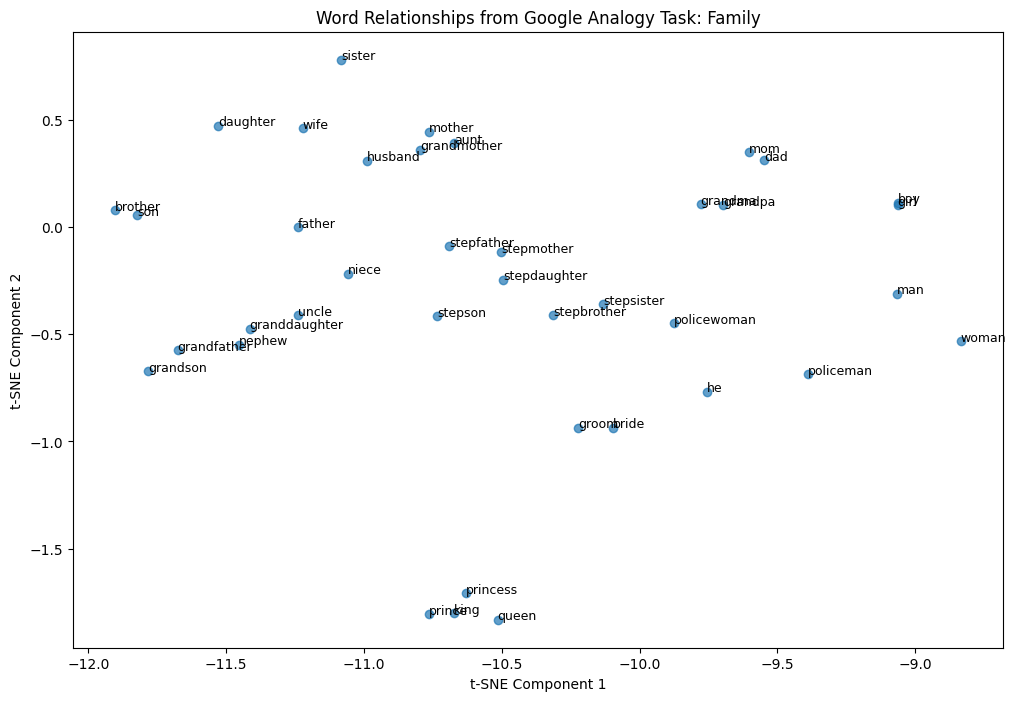

In [35]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# 過濾出子類別為 ": family" 的問題
family_data = data[data["SubCategory"] == SUB_CATEGORY]

# 提取單詞
words = set()  # 使用集合以避免重複
for analogy in family_data["Question"]:
    words.update(analogy.split())

words = list(words)  # 轉換為列表

# 儲存字詞與對應的向量
word_vectors = []
valid_words = []

for word in words:
    if word in model.wv:  # 確保單詞在詞模型中
        word_vectors.append(model.wv[word])
        valid_words.append(word)

# 將詞向量轉換為 NumPy 陣列
word_vectors = np.array(word_vectors)

# 使用 t-SNE 降維
tsne = TSNE(n_components=2, random_state=42)
word_vectors_tsne = tsne.fit_transform(word_vectors)

# 繪製 t-SNE 圖
plt.figure(figsize=(12, 8))
plt.scatter(word_vectors_tsne[:, 0], word_vectors_tsne[:, 1], alpha=0.7)

# 標記每個點
for i, word in enumerate(valid_words):
    plt.annotate(word, (word_vectors_tsne[i, 0], word_vectors_tsne[i, 1]), fontsize=9)

plt.title("Word Relationships from Google Analogy Task: Family")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# 保存圖形
plt.savefig("word_relationships-v2.png", bbox_inches="tight")
plt.show()
